# Capstone project: predict Rossmann's store sales

## Manuel Freude, May 2018

## Sales prediction code

Report and library sheets will be provided separately

### Exploratory data analysis

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

data = pd.read_csv('cleaned_dataset.csv')
data.drop(columns=['Unnamed: 0'] , inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 54 columns):
Intercept                    1017209 non-null int64
Store_ID                     1017209 non-null int64
Customers                    1017209 non-null int64
Sales                        1017209 non-null int64
Open                         1017209 non-null int64
H_None                       1017209 non-null int64
H_Public                     1017209 non-null int64
H_Easter                     1017209 non-null int64
H_X-Mas                      1017209 non-null int64
SchoolHoliday                1017209 non-null int64
Type_A                       1017209 non-null int64
Type_B                       1017209 non-null int64
Type_C                       1017209 non-null int64
Type_D                       1017209 non-null int64
Assort_Basic                 1017209 non-null int64
Assort_Extra                 1017209 non-null int64
Assort_Extended              1017209 non-null int64
Pro

In [2]:
# changing Store_ID datatype and looking at the head

data['Store_ID'] = data['Store_ID'].astype(object, inplace=True)

data.head()

,Intercept,Store_ID,Customers,Sales,Open,H_None,H_Public,H_Easter,H_X-Mas,SchoolHoliday,...,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,1,1,555,5263,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,1,546,5020,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,1,1,523,4782,1,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,1,560,5011,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,1,1,612,6102,1,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


There are many dummy variables in the dataset, but also numerical ones. For the numerical ones, I need to check if they are rather normally distributed so that they fit the regression approach. I will do this with the following ones: 
- Customers
- Sales
- DayOfMonth
- DayOfWeek
- Month
- Year

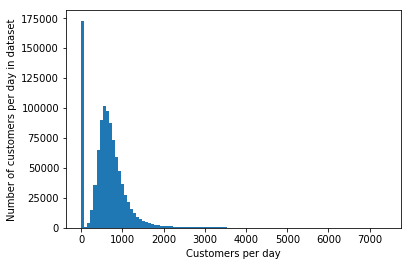

In [3]:
# plotting customers

pyplot.hist(data['Customers'], bins=100)
pyplot.ylabel('Number of customers per day in dataset')
pyplot.xlabel('Customers per day');

In [4]:
# checkig on the lower outlier

# source: https://stackoverflow.com/questions/35364601/group-by-and-find-top-n-value-counts-pandas

data['Customers'].value_counts().nlargest(5)

0      172869
560      2414
576      2363
603      2337
571      2330
Name: Customers, dtype: int64

This looks rather normally distributed. There are abnormalities where the customer number is zero. This might either indicated that the shop was not visited at all that day or it was a holiday etc., in that case I would expect the sales numbers to also be zero in many cases. 

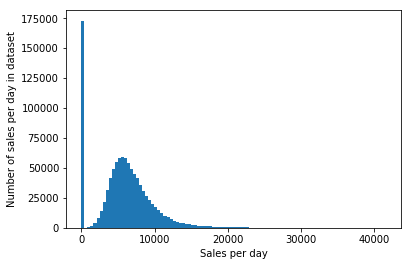

In [5]:
# plotting sales

pyplot.hist(data['Sales'], bins=100)
pyplot.ylabel('Number of sales per day in dataset')
pyplot.xlabel('Sales per day');

In [6]:
# checkig on the lower outlier

data['Sales'].value_counts().nlargest(5)

0       172871
5674       215
5558       197
5483       196
6049       195
Name: Sales, dtype: int64

Similar to customers, the data looks rather normally distributed except for the zero. The number of zeros is very high and almost the same as for the customers number. It might make sense to later on take a subset of the data to exclude the zeros and check how the regressions perform. The holidays will loose their relevancy in that case.

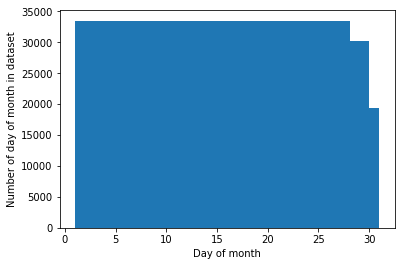

In [7]:
# plotting day of month

pyplot.hist(data['DayOfMonth'], bins=31)
pyplot.ylabel('Number of day of month in dataset')
pyplot.xlabel('Day of month');

Days of month look well-distributed. I was testing if there are any ones really low, but that's not the case. After 28, they decrease due to February usually not having more than 28 days and many months not having 31 days.

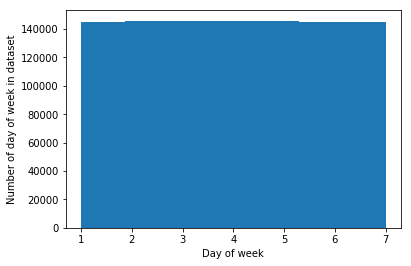

In [8]:
# plotting day of week

pyplot.hist(data['DayOfWeek'], bins=7)
pyplot.ylabel('Number of day of week in dataset')
pyplot.xlabel('Day of week');

In [9]:
# checking some numbers

data['DayOfWeek'].value_counts()

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

Sundays are also included, might be days with low sales because shops would be closed most of the time.

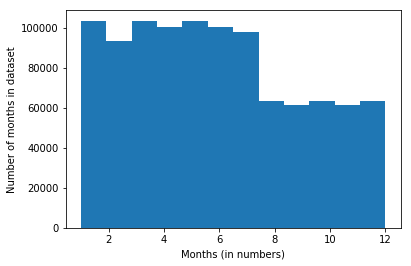

In [10]:
# plotting month

pyplot.hist(data['Month'], bins=12)
pyplot.ylabel('Number of months in dataset')
pyplot.xlabel('Months (in numbers)');

In [11]:
# checking some numbers

data['Month'].value_counts()

5     103695
3     103695
1     103694
6     100350
4     100350
7      98115
2      93660
12     63550
10     63550
8      63550
11     61500
9      61500
Name: Month, dtype: int64

All months are included. The second half of the year a little less, due to the structure of the provided data, which is not covering full years 2013 through 2015.

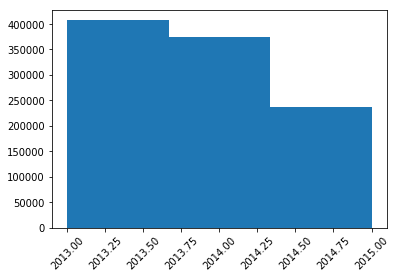

In [12]:
# plotting year

pyplot.hist(data['Year'], bins=3)
pyplot.xticks(rotation=45);

In [13]:
# checking some numbers

data['Year'].value_counts()

2013    406974
2014    373855
2015    236380
Name: Year, dtype: int64

Here we can see that we have less data for 2015, as guessed above. So overall, the data looks good for analysis. Next step is to split the dataset into train, test and true set. 

#### Multiple instance time series split

In [14]:
# making sure we sort the dataset by date to set ground for time series split

data.sort_values('Date', inplace=True);

data.head()

,Intercept,Store_ID,Customers,Sales,Open,H_None,H_Public,H_Easter,H_X-Mas,SchoolHoliday,...,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Sun
1017208,1,1115,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
679363,1,746,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
155193,1,171,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
632403,1,694,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
361623,1,396,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [15]:
data['Date'].head(10)

1017208    2013-01-01
679363     2013-01-01
155193     2013-01-01
632403     2013-01-01
361623     2013-01-01
177271     2013-01-01
246633     2013-01-01
29407      2013-01-01
401231     2013-01-01
994762     2013-01-01
Name: Date, dtype: object

In [16]:
data['Date'].tail(10)

812458    2015-07-31
559230    2015-07-31
886552    2015-07-31
94082     2015-07-31
558288    2015-07-31
557530    2015-07-31
212332    2015-07-31
982701    2015-07-31
769288    2015-07-31
0         2015-07-31
Name: Date, dtype: object

In [17]:
# source: https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

train_size = int(len(data['Date']) * 0.70)
test_size = int(len(data['Date']) * 0.85)
train, test, true = data[0:train_size], data[train_size:test_size], data[test_size:len(data['Date'])]
print('Observations: %d' % (len(data)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
print('"True" Observations: %d' % (len(true)))

Observations: 1017209
Training Observations: 712046
Testing Observations: 152581
"True" Observations: 152582


In [18]:
# comparing heads and info to make sure worked properly (train)

train.head()

,Intercept,Store_ID,Customers,Sales,Open,H_None,H_Public,H_Easter,H_X-Mas,SchoolHoliday,...,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Sun
1017208,1,1115,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
679363,1,746,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
155193,1,171,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
632403,1,694,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
361623,1,396,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [19]:
# comparing heads and info to make sure worked properly (train)

train['Date'].head()

1017208    2013-01-01
679363     2013-01-01
155193     2013-01-01
632403     2013-01-01
361623     2013-01-01
Name: Date, dtype: object

In [20]:
# comparing heads and info to make sure worked properly (train)

train['Date'].tail()

233157    2014-10-19
507293    2014-10-19
477311    2014-10-19
799165    2014-10-19
401517    2014-10-19
Name: Date, dtype: object

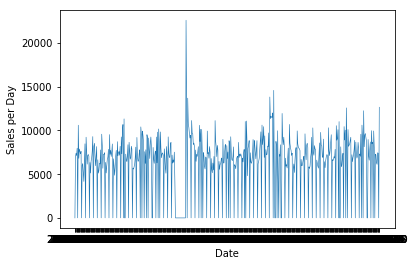

In [21]:
# plotting early 60% of sales per day for selected shop

x = train.loc[train['Store_ID'] == 100]
x = x['Date']
y = train.loc[train['Store_ID'] == 100]
y = y['Sales']

pyplot.plot(x, y, linewidth = 0.6)
pyplot.ylabel('Sales per Day')
pyplot.xlabel('Date')
pyplot.show;

In [22]:
# comparing heads to make sure worked properly (test)

test.head()

,Intercept,Store_ID,Customers,Sales,Open,H_None,H_Public,H_Easter,H_X-Mas,SchoolHoliday,...,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Sun
422057,1,463,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
200555,1,222,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
963572,1,1057,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
217327,1,240,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
536701,1,589,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [23]:
# comparing heads and info to make sure worked properly (test)

test['Date'].head()

422057    2014-10-19
200555    2014-10-19
963572    2014-10-19
217327    2014-10-19
536701    2014-10-19
Name: Date, dtype: object

In [24]:
# comparing heads and info to make sure worked properly (test)

test['Date'].tail()

301450    2015-03-17
300508    2015-03-17
205116    2015-03-17
515622    2015-03-17
437554    2015-03-17
Name: Date, dtype: object

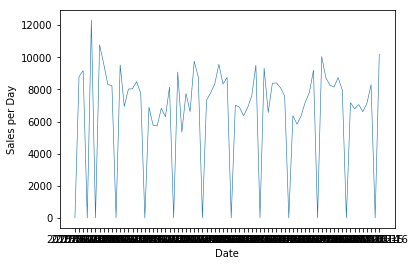

In [25]:
# plotting upper 60-80% of sales per day for selected shop

x = test.loc[test['Store_ID'] == 100]
x = x['Date']
y = test.loc[test['Store_ID'] == 100]
y = y['Sales']

pyplot.plot(x, y, linewidth = 0.6)
pyplot.ylabel('Sales per Day')
pyplot.xlabel('Date')
pyplot.show;

In [26]:
# comparing heads to make sure worked properly (true)

true.head()

,Intercept,Store_ID,Customers,Sales,Open,H_None,H_Public,H_Easter,H_X-Mas,SchoolHoliday,...,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Sun
553140,1,607,523,5400,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
253754,1,280,512,6653,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
491866,1,540,500,8025,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
297682,1,328,571,5069,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
654618,1,720,712,7987,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [27]:
# comparing heads to make sure worked properly (true)

true['Date'].head()

553140    2015-03-17
253754    2015-03-17
491866    2015-03-17
297682    2015-03-17
654618    2015-03-17
Name: Date, dtype: object

In [28]:
# comparing heads to make sure worked properly (true)

true['Date'].tail()

557530    2015-07-31
212332    2015-07-31
982701    2015-07-31
769288    2015-07-31
0         2015-07-31
Name: Date, dtype: object

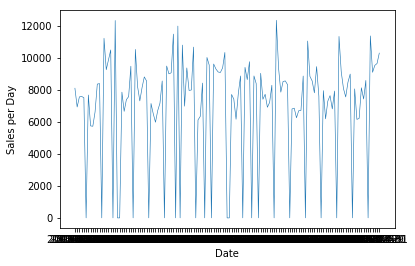

In [29]:
# plotting upper 20% of sales per day for selected shop

x = true.loc[true['Store_ID'] == 100]
x = x['Date']
y = true.loc[true['Store_ID'] == 100]
y = y['Sales']

pyplot.plot(x, y, linewidth = 0.6)
pyplot.ylabel('Sales per Day')
pyplot.xlabel('Date')
pyplot.show;

# Correlation heatmap

In [30]:
# looking at variables to find numeric ones for correlation checks

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712046 entries, 1017208 to 401517
Data columns (total 54 columns):
Intercept                    712046 non-null int64
Store_ID                     712046 non-null object
Customers                    712046 non-null int64
Sales                        712046 non-null int64
Open                         712046 non-null int64
H_None                       712046 non-null int64
H_Public                     712046 non-null int64
H_Easter                     712046 non-null int64
H_X-Mas                      712046 non-null int64
SchoolHoliday                712046 non-null int64
Type_A                       712046 non-null int64
Type_B                       712046 non-null int64
Type_C                       712046 non-null int64
Type_D                       712046 non-null int64
Assort_Basic                 712046 non-null int64
Assort_Extra                 712046 non-null int64
Assort_Extended              712046 non-null int64
Promo1         

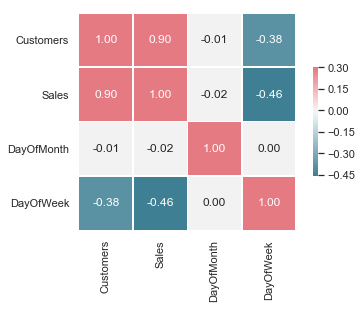

In [31]:
# plotting a correlation heatmap
# source: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

sns.set(style="white")

train_corr = train[['Customers', 'Sales', 'DayOfMonth', 'DayOfWeek']]

corr = train_corr.corr()

f, ax = pyplot.subplots()

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Benchmark model

### "All in one" linear regression model

In [32]:
# setting up the linear regression benchmark model

# source: http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py
# source: https://stackoverflow.com/questions/33113947/using-scikit-learn-sklearn-how-to-handle-missing-data-for-linear-regression

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import Imputer, normalize, StandardScaler

imputer = Imputer()

X_train = train.drop(['Store_ID', 'Sales', 'Date'], axis=1)
X_train = imputer.fit_transform(X_train)

y_train = train['Sales']

X_test = test.drop(['Store_ID', 'Sales', 'Date'], axis=1)
X_test = imputer.transform(X_test)

y_test = test['Sales']

l_reg = linear_model.LinearRegression()
l_reg.fit(X_train, y_train)
sales_lr_pred = l_reg.predict(X_test)

# printing output coefficients

print('Coefficients: \n', l_reg.coef_)

# mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, sales_lr_pred))

# explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, sales_lr_pred))

Coefficients: 
 [-9.41520159e-14  7.09126272e+00  1.09805865e+03  9.32160900e+01
 -1.90264285e+02 -6.59785226e+02 -3.94834889e+02  1.46313787e+02
  5.64124251e+02 -2.45831092e+03  4.51367966e+02  1.44281870e+03
  1.20115462e+03 -2.65816308e+03  1.45700846e+03  1.24839707e+03
  1.29160730e+02  5.78995376e+00 -4.89661320e+01  5.72815240e+01
  1.26596866e+02 -5.47176602e+01  1.92087015e-02 -3.57295000e+00
 -2.05497568e+00  8.02679038e-01 -1.01386626e+01  3.26479349e+01
  4.57311853e+01 -4.57311853e+01  4.57311853e+01 -1.70530257e-13
  1.01989014e+02  7.98786361e+01  6.53644674e+01 -1.80830772e+01
  3.88284421e+00 -1.10668740e+01 -6.29655511e+01 -2.02729146e+02
 -2.38262312e+02 -2.56539106e+02 -4.09822180e+00  5.42629325e+02
  3.82857139e+02 -1.08871071e+02 -2.13040191e+02 -2.76736892e+02
 -1.40395737e+02  2.20514100e+02  1.35672653e+02]
Mean squared error: 1459139.90
Variance score: 0.91


In [33]:
# conducting a regression with statsmodel for better coefficient summary

import statsmodels.api as sm

imputer = Imputer()

X_train = train.drop(['Store_ID', 'Sales', 'Date'], axis=1)
X_train = imputer.fit_transform(X_train)

y_train = train['Sales']

X_test = test.drop(['Store_ID', 'Sales', 'Date'], axis=1)
X_test = imputer.fit_transform(X_test)

y_test = test['Sales']

sm_lr_model = sm.OLS(y_train, X_train)
results = sm_lr_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 1.726e+05
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:40:25   Log-Likelihood:            -6.0346e+06
No. Observations:              712046   AIC:                         1.207e+07
Df Residuals:                  712005   BIC:                         1.207e+07
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.205      0.0

This is a warning as expected because I included all dummy variables in the model. As a next step, I will build a basic model and add complexity to see how many variables and which variables should be included. 

## "Basic" model

In [34]:
# running l_reg for basic model, day of month is out due to missing correlation identified above

X_train = train[['Customers', 'DayOfWeek']]
X_train = imputer.fit_transform(X_train)
y_train = train['Sales']

X_test = test[['Customers', 'DayOfWeek']]
X_test = imputer.fit_transform(X_test)
y_test = test['Sales']

l_reg = linear_model.LinearRegression()
l_reg.fit(X_train, y_train)
sales_lr_pred = l_reg.predict(X_test)

# printing output coefficients

print('Coefficients: \n', l_reg.coef_)

# mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, sales_lr_pred))

# explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, sales_lr_pred))

Coefficients: 
 [   6.92371801 -253.8037436 ]
Mean squared error: 2906582.11
Variance score: 0.82


In [35]:
# running statsmodel regression with basic model with an intercept

X_train = train[['Intercept', 'Customers', 'DayOfWeek']]
X_train = imputer.fit_transform(X_train)
y_train = train['Sales']

X_test = test[['Intercept', 'Customers', 'DayOfWeek']]
X_test = imputer.fit_transform(X_test)
y_test = test['Sales']

sm_lr_model = sm.OLS(y_train, X_train)
results = sm_lr_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                 1.617e+06
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:40:26   Log-Likelihood:            -6.2686e+06
No. Observations:              712046   AIC:                         1.254e+07
Df Residuals:                  712043   BIC:                         1.254e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2322.2143      6.135    378.507      0.0

## "Store type" model

In [36]:
# running l_reg for store type model

X_train = train[['Customers', 'DayOfWeek', 'Type_B', 'Type_C', 'Type_D']]
X_train = imputer.fit_transform(X_train)
y_train = train['Sales']

X_test = test[['Customers', 'DayOfWeek', 'Type_B', 'Type_C', 'Type_D']]
X_test = imputer.fit_transform(X_test)
y_test = test['Sales']

l_reg = linear_model.LinearRegression()
l_reg.fit(X_train, y_train)
sales_lr_pred = l_reg.predict(X_test)

# printing output coefficients

print('Coefficients: \n', l_reg.coef_)

# mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, sales_lr_pred))

# explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, sales_lr_pred))

Coefficients: 
 [    7.86043875  -170.56133689 -6087.04841445  -129.95954114
  1126.4133212 ]
Mean squared error: 2075448.45
Variance score: 0.87


In [37]:
# running statsmodel regression with store type model with an intercept

X_train = train[['Intercept', 'Customers', 'DayOfWeek', 'Type_B', 'Type_C', 'Type_D']]
X_train = imputer.fit_transform(X_train)
y_train = train['Sales']

X_test = test[['Intercept', 'Customers', 'DayOfWeek', 'Type_B', 'Type_C', 'Type_D']]
X_test = imputer.fit_transform(X_test)
y_test = test['Sales']

sm_lr_model = sm.OLS(y_train, X_train)
results = sm_lr_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                 9.690e+05
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:40:27   Log-Likelihood:            -6.1468e+06
No. Observations:              712046   AIC:                         1.229e+07
Df Residuals:                  712040   BIC:                         1.229e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1162.8277      5.740    202.595      0.0

Store type added value for clearing more r squared, I keep it in. Statsmodels shows a multicollinearity or "other numerical problems" warning, I will carefully watch not adding to any multicollinearity problems when selecting dummy variables. 

## "Store type and assortment" model

In [38]:
# running l_reg for store type and assortment model

X_train = train[['Customers', 'DayOfWeek', 'Type_B', 'Type_C', 'Type_D', 'Assort_Extra', 'Assort_Extended']]
X_train = imputer.fit_transform(X_train)
y_train = train['Sales']

X_test = test[['Customers', 'DayOfWeek', 'Type_B', 'Type_C', 'Type_D', 'Assort_Extra', 'Assort_Extended']]
X_test = imputer.fit_transform(X_test)
y_test = test['Sales']

l_reg = linear_model.LinearRegression()
l_reg.fit(X_train, y_train)
sales_lr_pred = l_reg.predict(X_test)

# printing output coefficients

print('Coefficients: \n', l_reg.coef_)

# mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, sales_lr_pred))

# explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, sales_lr_pred))

Coefficients: 
 [    7.84841803  -171.62432495 -3977.01720985  -155.90621552
  1061.89214182 -3850.46700855   236.16605129]
Mean squared error: 1970282.80
Variance score: 0.88


In [39]:
# running statsmodel regression with store type and assortment model with an intercept

X_train = train[['Intercept', 'Customers', 'DayOfWeek', 'Type_B', 'Type_C', 'Type_D', 'Assort_Extra', 'Assort_Extended']]
X_train = imputer.fit_transform(X_train)
y_train = train['Sales']

X_test = test[['Intercept', 'Customers', 'DayOfWeek', 'Type_B', 'Type_C', 'Type_D', 'Assort_Extra', 'Assort_Extended']]
X_test = imputer.fit_transform(X_test)
y_test = test['Sales']

sm_lr_model = sm.OLS(y_train, X_train)
results = sm_lr_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                 7.240e+05
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:40:27   Log-Likelihood:            -6.1328e+06
No. Observations:              712046   AIC:                         1.227e+07
Df Residuals:                  712038   BIC:                         1.227e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1087.3105      5.710    190.433      0.0

This added a little more explanatory value. I'll now build the full linear regression model with correct dummy variables.

## Scoring setup and final benchmark model

In [40]:
# building the scores and time dataframe for performance comparison

scores = pd.DataFrame(columns=['Regressor', 'RMSPE', 'MSE', 'R2', 'Time'])

In [41]:
# building the RMSPE function, sourced from kaggle discussion forum
# https://www.kaggle.com/c/rossmann-store-sales/discussion/16908#latest-95593

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def RMSPE_fct(y, yhat):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

In [105]:
# preparing the final datasets for train and test

imputer = Imputer()

X_train = train.drop(['Intercept',
                      'Store_ID', 
                      'Sales', 
                      'Date', 
                      'DayOfMonth', 
                      'Type_A', 
                      'Assort_Basic', 
                      'Promo2_Feb,May,Aug,Nov',
                      'Year',
                      '2013',
                      'Jan',
                      'Mon'], axis=1)

X_train = imputer.fit_transform(X_train)

y_train = train['Sales']

X_test = test.drop(['Intercept',
                      'Store_ID', 
                      'Sales', 
                      'Date', 
                      'DayOfMonth', 
                      'Type_A', 
                      'Assort_Basic', 
                      'Promo2_Feb,May,Aug,Nov',
                      'Year',
                      '2013',
                      'Jan',
                      'Mon'], axis=1)

X_test = imputer.fit_transform(X_test)

y_test = test['Sales']

In [106]:
# setting up the linear regression benchmark model

start_time = datetime.now()

l_reg = linear_model.LinearRegression()
l_reg.fit(X_train, y_train)
sales_lr_pred = l_reg.predict(X_test)

regressor = 'Linear Reg'
RMSPE = RMSPE_fct(y_test, sales_lr_pred)
MSE = mean_squared_error(y_test, sales_lr_pred)
R2 = r2_score(y_test, sales_lr_pred)

# time 

time_elapsed = datetime.now() - start_time 

# scores 

scores = scores.append(pd.Series([regressor, RMSPE, MSE, R2, time_elapsed], index=scores.columns), ignore_index=True)

print('Mean squared error: %.2f' % MSE)
print('Root mean squared percentage error: %.2f' % RMSPE)
print('Variance score: %.2f' % R2)
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Mean squared error: 1474975.36
Root mean squared percentage error: 0.18
Variance score: 0.91
Time elapsed (hh:mm:ss.ms) 0:00:00.802518


In [44]:
# running statsmodel regression with store type and assortment model with an intercept

X_train = train.drop(['Store_ID', 
                      'Sales', 
                      'Date', 
                      'DayOfMonth', 
                      'Type_A', 
                      'Assort_Basic', 
                      'Promo2_Feb,May,Aug,Nov',
                      'Year',
                      '2013',
                      'Jan',
                      'Mon'], axis=1)

X_train = imputer.fit_transform(X_train)
y_train = train['Sales']

X_test = test.drop(['Store_ID', 
                      'Sales', 
                      'Date', 
                      'DayOfMonth', 
                      'Type_A', 
                      'Assort_Basic', 
                      'Promo2_Feb,May,Aug,Nov',
                      'Year',
                      '2013',
                      'Mon',
                      'Jan'], axis=1)

X_test = imputer.fit_transform(X_test)
y_test = test['Sales']

sm_lr_model = sm.OLS(y_train, X_train)
results = sm_lr_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                 1.770e+05
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:40:34   Log-Likelihood:            -6.0347e+06
No. Observations:              712046   AIC:                         1.207e+07
Df Residuals:                  712006   BIC:                         1.207e+07
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.008e+05   2490.914     40.484      0.0

The overall r squared and mean squared error values are just about the same as in the "all in one model", I have cleared out some multicollinear variables and will use this final benchmark model going forward. 

# Model preparation

## Preparing the data

In [108]:
X_train = train.drop(['Intercept',
                      'Store_ID', 
                      'Sales', 
                      'Date', 
                      'DayOfMonth', 
                      'Type_A', 
                      'Assort_Basic', 
                      'Promo2_Feb,May,Aug,Nov',
                      'Year',
                      '2013',
                      'Jan',
                      'Mon'], axis=1)

X_train.info()

train_columns = X_train.columns.values

X_train = imputer.fit_transform(X_train)

y_train = train['Sales']

X_test = test.drop(['Intercept',
                      'Store_ID', 
                      'Sales', 
                      'Date', 
                      'DayOfMonth', 
                      'Type_A', 
                      'Assort_Basic', 
                      'Promo2_Feb,May,Aug,Nov',
                      'Year',
                      '2013',
                      'Jan',
                      'Mon'], axis=1)

X_test = imputer.fit_transform(X_test)

y_test = test['Sales']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 712046 entries, 1017208 to 401517
Data columns (total 42 columns):
Customers                    712046 non-null int64
Open                         712046 non-null int64
H_None                       712046 non-null int64
H_Public                     712046 non-null int64
H_Easter                     712046 non-null int64
H_X-Mas                      712046 non-null int64
SchoolHoliday                712046 non-null int64
Type_B                       712046 non-null int64
Type_C                       712046 non-null int64
Type_D                       712046 non-null int64
Assort_Extra                 712046 non-null int64
Assort_Extended              712046 non-null int64
Promo1                       712046 non-null int64
Promo2                       712046 non-null int64
Promo2SinceWeek              357603 non-null float64
Promo2SinceYear              357603 non-null float64
Promo2_Jan,Apr,Jul,Oct       712046 non-null int64
Promo2_Mar,J

## Support Vector Regression (Linear SVR)

In [46]:
# source: http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR

from sklearn.svm import LinearSVR

start_time = datetime.now()

SVR = LinearSVR()
SVR.fit(X_train, y_train)
SVR_pred = SVR.predict(X_test)

regressor = 'LinearSVR'
RMSPE = RMSPE_fct(y_test, SVR_pred)
MSE = mean_squared_error(y_test, SVR_pred)
R2 = r2_score(y_test, SVR_pred)

# time 

time_elapsed = datetime.now() - start_time 

# scores 

scores = scores.append(pd.Series([regressor, RMSPE, MSE, R2, time_elapsed], index=scores.columns), ignore_index=True)

print('Mean squared error: %.2f' % MSE)
print('Root mean squared percentage error: %.2f' % RMSPE)
print('Variance score: %.2f' % R2)
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Mean squared error: 21940944.71
Root mean squared percentage error: 1.02
Variance score: -0.38
Time elapsed (hh:mm:ss.ms) 0:04:20.598299


## ElasticNet

In [47]:
# source: http://scikit-learn.org/stable/modules/linear_model.html#elastic-net

from sklearn.linear_model import ElasticNet

start_time = datetime.now()

Elastic = ElasticNet()
Elastic.fit(X_train, y_train)
Elastic_pred = Elastic.predict(X_test)

regressor = 'ElasticNet'
RMSPE = RMSPE_fct(y_test, Elastic_pred)
MSE = mean_squared_error(y_test, Elastic_pred)
R2 = r2_score(y_test, Elastic_pred)

# time 

time_elapsed = datetime.now() - start_time 

# scores 

scores = scores.append(pd.Series([regressor, RMSPE, MSE, R2, time_elapsed], index=scores.columns), ignore_index=True)

print('Mean squared error: %.2f' % MSE)
print('Root mean squared percentage error: %.2f' % RMSPE)
print('Variance score: %.2f' % R2)
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Mean squared error: 2348652.10
Root mean squared percentage error: 0.20
Variance score: 0.85
Time elapsed (hh:mm:ss.ms) 0:00:01.245563


## Lasso

In [48]:
# source: http://scikit-learn.org/stable/modules/linear_model.html#lasso

start_time = datetime.now()

lasso = linear_model.Lasso()
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

regressor = 'Lasso'
RMSPE = RMSPE_fct(y_test, lasso_pred)
MSE = mean_squared_error(y_test, lasso_pred)
R2 = r2_score(y_test, lasso_pred)

# time 

time_elapsed = datetime.now() - start_time 

# scores 

scores = scores.append(pd.Series([regressor, RMSPE, MSE, R2, time_elapsed], index=scores.columns), ignore_index=True)

print('Mean squared error: %.2f' % MSE)
print('Root mean squared percentage error: %.2f' % RMSPE)
print('Variance score: %.2f' % R2)
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Mean squared error: 1474663.93
Root mean squared percentage error: 0.18
Variance score: 0.91
Time elapsed (hh:mm:ss.ms) 0:00:07.476967


## Light Gradient Boosting Machine

In [49]:
# https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/sklearn.html

import lightgbm as lgb

start_time = datetime.now()

train_data = lgb.Dataset(X_train, label=y_train)

lgb = lgb.LGBMRegressor()
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

regressor = 'LGBM'
RMSPE = RMSPE_fct(y_test, lgb_pred)
MSE = mean_squared_error(y_test, lgb_pred)
R2 = r2_score(y_test, lgb_pred)

# time 

time_elapsed = datetime.now() - start_time 

# scores 

scores = scores.append(pd.Series([regressor, RMSPE, MSE, R2, time_elapsed], index=scores.columns), ignore_index=True)

print('Mean squared error: %.2f' % MSE)
print('Root mean squared percentage error: %.2f' % RMSPE)
print('Variance score: %.2f' % R2)
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

/Users/manuelfreude/anaconda3/envs/tensorflow/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


Mean squared error: 626775.16
Root mean squared percentage error: 0.13
Variance score: 0.96
Time elapsed (hh:mm:ss.ms) 0:00:05.742142


## XGBoost regressor

In [50]:
# source: https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

from xgboost import XGBRegressor

start_time = datetime.now()

XGB = XGBRegressor()
XGB.fit(X_train, y_train)
XGB_pred = XGB.predict(X_test)

regressor = 'XGBoost'
RMSPE = RMSPE_fct(y_test, XGB_pred)
MSE = mean_squared_error(y_test, XGB_pred)
R2 = r2_score(y_test, XGB_pred)

# time 

time_elapsed = datetime.now() - start_time 

# scores 

scores = scores.append(pd.Series([regressor, RMSPE, MSE, R2, time_elapsed], index=scores.columns), ignore_index=True)

print('Mean squared error: %.2f' % MSE)
print('Root mean squared percentage error: %.2f' % RMSPE)
print('Variance score: %.2f' % R2)
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Mean squared error: 947606.79
Root mean squared percentage error: 0.13
Variance score: 0.94
Time elapsed (hh:mm:ss.ms) 0:01:22.458597


## MLP regressor

In [51]:
# source: http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

from sklearn.neural_network import MLPRegressor

start_time = datetime.now()

MLP = MLPRegressor()
MLP.fit(X_train, y_train)
MLP_pred = MLP.predict(X_test)

regressor = 'Neural Net'
RMSPE = RMSPE_fct(y_test, MLP_pred)
MSE = mean_squared_error(y_test, MLP_pred)
R2 = r2_score(y_test, MLP_pred)

# time 

time_elapsed = datetime.now() - start_time 

# scores 

scores = scores.append(pd.Series([regressor, RMSPE, MSE, R2, time_elapsed], index=scores.columns), ignore_index=True)

print('Mean squared error: %.2f' % MSE)
print('Root mean squared percentage error: %.2f' % RMSPE)
print('Variance score: %.2f' % R2)
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Mean squared error: 941626.04
Root mean squared percentage error: 0.13
Variance score: 0.94
Time elapsed (hh:mm:ss.ms) 0:07:59.506354


## AdaBoost regressor

In [52]:
# source: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

from sklearn.ensemble import AdaBoostRegressor

start_time = datetime.now()

Ada = AdaBoostRegressor(base_estimator=linear_model.LinearRegression(), learning_rate=0.005)
Ada.fit(X_train, y_train)
Ada_pred = Ada.predict(X_test)

regressor = 'AdaBoost'
RMSPE = RMSPE_fct(y_test, Ada_pred)
MSE = mean_squared_error(y_test, Ada_pred)
R2 = r2_score(y_test, Ada_pred)

# time 

time_elapsed = datetime.now() - start_time 

# scores 

scores = scores.append(pd.Series([regressor, RMSPE, MSE, R2, time_elapsed], index=scores.columns), ignore_index=True)

print('Mean squared error: %.2f' % MSE)
print('Root mean squared percentage error: %.2f' % RMSPE)
print('Variance score: %.2f' % R2)
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

/Users/manuelfreude/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Mean squared error: 1474299.82
Root mean squared percentage error: 0.18
Variance score: 0.91
Time elapsed (hh:mm:ss.ms) 0:01:47.173080


## Performance comparison

In [53]:
scores

,Regressor,RMSPE,MSE,R2,Time
0,Linear Reg,0.184117,1.474975e+06,0.907479,00:00:00.999722
1,LinearSVR,1.016006,2.194094e+07,-0.376297,00:04:20.598299
2,ElasticNet,0.199590,2.348652e+06,0.852675,00:00:01.245563
3,Lasso,0.182485,1.474664e+06,0.907498,00:00:07.476967
4,LGBM,0.134949,6.267752e+05,0.960684,00:00:05.742142
5,XGBoost,0.128395,9.476068e+05,0.940559,00:01:22.458597
6,Neural Net,0.131720,9.416260e+05,0.940934,00:07:59.506354
7,AdaBoost,0.184656,1.474300e+06,0.907521,00:01:47.173080


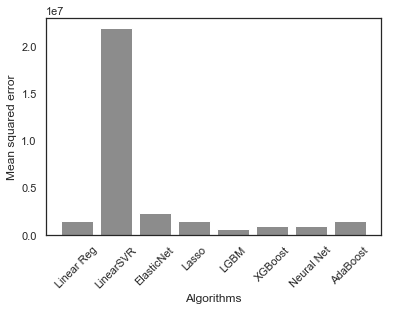

In [54]:
pyplot.bar(scores['Regressor'], scores['MSE'], color='C7')
pyplot.xticks(rotation=45)
pyplot.ylabel('Mean squared error')
pyplot.xlabel('Algorithms');

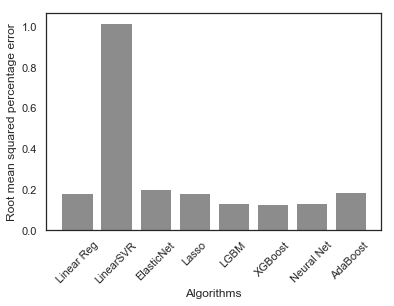

In [55]:
pyplot.bar(scores['Regressor'], scores['RMSPE'], color='C7')
pyplot.xticks(rotation=45)
pyplot.ylabel('Root mean squared percentage error')
pyplot.xlabel('Algorithms');

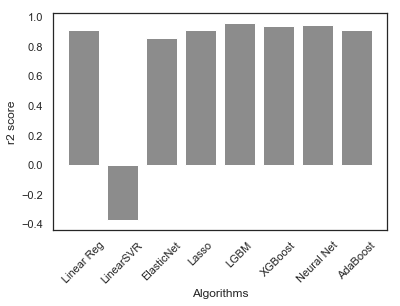

In [56]:
pyplot.bar(scores['Regressor'], scores['R2'], color='C7')
pyplot.xticks(rotation=45)
pyplot.ylabel('r2 score')
pyplot.xlabel('Algorithms');

# Fine-tuning of three top-performing models

### Grid search of LGBM

In [57]:
# Use grid search for https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/sklearn.html
# Params useful for grid search in LGB: num_leaves, max_depth, n_estimators and learning rate

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import lightgbm as lgb

start_time = datetime.now() 

train_data = lgb.Dataset(X_train, label=y_train)

lgb_simple = lgb.LGBMRegressor(boosting_type='gbdt')

rmspe_scorer = make_scorer(RMSPE_fct, greater_is_better=False)

num_leaves = [10, 25, 50]

max_depth = [5, 10]

n_estimators = [100, 200]

learning_rate = [0.01, 0.1]

param_grid = dict(num_leaves= num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)

grid_search = GridSearchCV(lgb_simple, param_grid, scoring=rmspe_scorer, n_jobs=-1, cv=5, return_train_score=True)
grid_result = grid_search.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
time_elapsed = datetime.now() - start_time 

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Best: -0.088474 using {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 50}
-0.242222 (0.012632) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 10}
-0.229083 (0.014457) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 25}
-0.226792 (0.014307) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 50}
-0.181722 (0.008691) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 10}
-0.168152 (0.009673) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 25}
-0.167268 (0.010216) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 50}
-0.242222 (0.012632) with: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 10}
-0.228498 (0.013919) with: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 25}
-0.222288 (0.013746) with: {'learning_rate': 0.01

#### Best LGBM performer

In [58]:
# https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/sklearn.html
# Grid search results 0.088474 (0.003967) with: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 50}

import lightgbm as lgb

start_time = datetime.now()

train_data = lgb.Dataset(X_train, label=y_train)

lgb = lgb.LGBMRegressor(learning_rate=0.1,
                        max_depth=10,
                        n_estimators=200,
                        num_leaves=50)

lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

regressor = 'LGBM (tuned)'
RMSPE = RMSPE_fct(y_test, lgb_pred)
MSE = mean_squared_error(y_test, lgb_pred)
R2 = r2_score(y_test, lgb_pred)

# time 

time_elapsed = datetime.now() - start_time 

# scores 

scores = scores.append(pd.Series([regressor, RMSPE, MSE, R2, time_elapsed], index=scores.columns), ignore_index=True)

print('Mean squared error: %.2f' % MSE)
print('Root mean squared percentage error: %.2f' % RMSPE)
print('Variance score: %.2f' % R2)
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Mean squared error: 404587.30
Root mean squared percentage error: 0.12
Variance score: 0.97
Time elapsed (hh:mm:ss.ms) 0:00:08.645948


### Grid search of MLP

In [59]:
# Using grid search for https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
# Params useful for grid search in MLP: alpha, hidden layer sizes

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

start_time = datetime.now()

MLP_simple = MLPRegressor()

rmspe_scorer = make_scorer(RMSPE_fct, greater_is_better=False)

hidden_layer_sizes = [(100, ), (200, ), (300, )]

alpha = [0.0001, 0.001, 0.01]

#param_grid = dict(learning_rate=eta, max_depth=max_depth, alpha=alpha, tree_method=tree_method)
param_grid = dict(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha)

grid_search = GridSearchCV(MLP_simple, param_grid, scoring=rmspe_scorer, n_jobs=-1, cv=5, return_train_score=True)
grid_result = grid_search.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

time_elapsed = datetime.now() - start_time 

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Best: -0.132289 using {'alpha': 0.01, 'hidden_layer_sizes': (300,)}
-0.136769 (0.002783) with: {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
-0.137921 (0.007542) with: {'alpha': 0.0001, 'hidden_layer_sizes': (200,)}
-0.133982 (0.003209) with: {'alpha': 0.0001, 'hidden_layer_sizes': (300,)}
-0.141891 (0.008426) with: {'alpha': 0.001, 'hidden_layer_sizes': (100,)}
-0.134168 (0.003076) with: {'alpha': 0.001, 'hidden_layer_sizes': (200,)}
-0.133947 (0.002414) with: {'alpha': 0.001, 'hidden_layer_sizes': (300,)}
-0.136833 (0.004220) with: {'alpha': 0.01, 'hidden_layer_sizes': (100,)}
-0.135260 (0.003269) with: {'alpha': 0.01, 'hidden_layer_sizes': (200,)}
-0.132289 (0.005734) with: {'alpha': 0.01, 'hidden_layer_sizes': (300,)}


ValueError: cannot reshape array of size 9 into shape (3,2)

#### Best MLP performer

In [61]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
# Grid search results -0.132289 using {'alpha': 0.01, 'hidden_layer_sizes': (300,)}

start_time = datetime.now()

MLP = MLPRegressor(activation='relu', 
                   solver='adam', 
                   alpha=0.01, 
                   batch_size=500, 
                   hidden_layer_sizes=(300,))

MLP.fit(X_train, y_train)
MLP_pred = MLP.predict(X_test)

regressor = 'MLP (tuned)'
RMSPE = RMSPE_fct(y_test, MLP_pred)
MSE = mean_squared_error(y_test, MLP_pred)
R2 = r2_score(y_test, MLP_pred)

# time 

time_elapsed = datetime.now() - start_time 

# scores 

scores = scores.append(pd.Series([regressor, RMSPE, MSE, R2, time_elapsed], index=scores.columns), ignore_index=True)

print('Mean squared error: %.2f' % MSE)
print('Root mean squared percentage error: %.2f' % RMSPE)
print('Variance score: %.2f' % R2)
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Mean squared error: 961660.59
Root mean squared percentage error: 0.13
Variance score: 0.94
Time elapsed (hh:mm:ss.ms) 0:18:18.715265


### GridSearch of XGBoost

In [62]:
# Using grid search for https://xgboost.readthedocs.io/en/latest/parameter.html
# Params useful for grid search in XGBoost: eta (learning rate), max_depth, alpha L1 regularization, tree_method

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

start_time = datetime.now()

XGBoost_simple = XGBRegressor()

rmspe_scorer = make_scorer(RMSPE_fct, greater_is_better=False)

eta = [0.001, 0.01, 0.1]

max_depth = [1, 10, 20]

#param_grid = dict(learning_rate=eta, max_depth=max_depth, alpha=alpha, tree_method=tree_method)
param_grid = dict(learning_rate=eta, max_depth=max_depth)

grid_search = GridSearchCV(XGBoost_simple, param_grid, scoring=rmspe_scorer, n_jobs=-1, cv=5, return_train_score=True)
grid_result = grid_search.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

time_elapsed = datetime.now() - start_time 

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Best: -0.067737 using {'learning_rate': 0.1, 'max_depth': 20}
-0.821740 (0.002517) with: {'learning_rate': 0.001, 'max_depth': 1}
-0.823083 (0.002923) with: {'learning_rate': 0.001, 'max_depth': 10}
-0.824069 (0.003020) with: {'learning_rate': 0.001, 'max_depth': 20}
-0.346348 (0.005231) with: {'learning_rate': 0.01, 'max_depth': 1}
-0.332482 (0.007152) with: {'learning_rate': 0.01, 'max_depth': 10}
-0.335710 (0.007333) with: {'learning_rate': 0.01, 'max_depth': 20}
-0.171330 (0.005457) with: {'learning_rate': 0.1, 'max_depth': 1}
-0.076699 (0.003363) with: {'learning_rate': 0.1, 'max_depth': 10}
-0.067737 (0.005679) with: {'learning_rate': 0.1, 'max_depth': 20}


AttributeError: module 'matplotlib' has no attribute 'plot'

#### Best XGBoost performer

In [63]:
# https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/
# Grid search results -0.067737 using {'learning_rate': 0.1, 'max_depth': 20}

from xgboost import XGBRegressor

start_time = datetime.now()

XGB = XGBRegressor(eta=0.1, max_depth=20)
XGB.fit(X_train, y_train)
XGB_pred = XGB.predict(X_test)

regressor = 'XGBoost (tuned)'
RMSPE = RMSPE_fct(y_test, XGB_pred)
MSE = mean_squared_error(y_test, XGB_pred)
R2 = r2_score(y_test, XGB_pred)

# time 

time_elapsed = datetime.now() - start_time 

# scores 

scores = scores.append(pd.Series([regressor, RMSPE, MSE, R2, time_elapsed], index=scores.columns), ignore_index=True)

print('Mean squared error: %.2f' % MSE)
print('Root mean squared percentage error: %.2f' % RMSPE)
print('Variance score: %.2f' % R2)
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Mean squared error: 275619.56
Root mean squared percentage error: 0.07
Variance score: 0.98
Time elapsed (hh:mm:ss.ms) 0:10:17.230833


In [64]:
scores

,Regressor,RMSPE,MSE,R2,Time
0,Linear Reg,0.184117,1.474975e+06,0.907479,00:00:00.999722
1,LinearSVR,1.016006,2.194094e+07,-0.376297,00:04:20.598299
2,ElasticNet,0.199590,2.348652e+06,0.852675,00:00:01.245563
3,Lasso,0.182485,1.474664e+06,0.907498,00:00:07.476967
4,LGBM,0.134949,6.267752e+05,0.960684,00:00:05.742142
5,XGBoost,0.128395,9.476068e+05,0.940559,00:01:22.458597
6,Neural Net,0.131720,9.416260e+05,0.940934,00:07:59.506354
7,AdaBoost,0.184656,1.474300e+06,0.907521,00:01:47.173080
8,LGBM (tuned),0.120544,4.045873e+05,0.974621,00:00:08.645948
9,MLP (tuned),0.125380,9.616606e+05,0.939678,00:18:18.715265


# Predicting the "true" dataset with top 3 algorithms

In [65]:
# preparing the true dataset

imputer = Imputer()

X_true = true.drop(['Intercept',
                    'Store_ID', 
                    'Sales', 
                    'Date', 
                    'DayOfMonth', 
                    'Type_A', 
                    'Assort_Basic', 
                    'Promo2_Feb,May,Aug,Nov',
                    'Year',
                    '2013',
                    'Jan', 
                    'Mon'], axis=1)

X_true = imputer.fit_transform(X_true)

y_true = true['Sales']

In [68]:
# MLP

MLP_pred = MLP.predict(X_true)

regressor = 'MLP (true)'
RMSPE = RMSPE_fct(y_true, MLP_pred)
MSE = mean_squared_error(y_true, MLP_pred)
R2 = r2_score(y_true, MLP_pred)

# time 

time_elapsed = 'n/a (prediction only)'

# scores 

scores = scores.append(pd.Series([regressor, RMSPE, MSE, R2, time_elapsed], index=scores.columns), ignore_index=True)

print('Mean squared error: %.2f' % MSE)
print('Root mean squared percentage error: %.2f' % RMSPE)
print('Variance score: %.2f' % R2)

Mean squared error: 1298959.10
Root mean squared percentage error: 0.13
Variance score: 0.92


In [69]:
# LGBM

lgb_pred = lgb.predict(X_true)

regressor = 'LGBM (true)'
RMSPE = RMSPE_fct(y_true, lgb_pred)
MSE = mean_squared_error(y_true, lgb_pred)
R2 = r2_score(y_true, lgb_pred)

# time

time_elapsed = 'n/a (prediction only)'

# scores 

scores = scores.append(pd.Series([regressor, RMSPE, MSE, R2, time_elapsed], index=scores.columns), ignore_index=True)

print('Mean squared error: %.2f' % MSE)
print('Root mean squared percentage error: %.2f' % RMSPE)
print('Variance score: %.2f' % R2)

Mean squared error: 594451.16
Root mean squared percentage error: 0.09
Variance score: 0.96


In [70]:
# XGBoost

XGB_pred = XGB.predict(X_true)

regressor = 'XGBoost (true)'
RMSPE = RMSPE_fct(y_true, XGB_pred)
MSE = mean_squared_error(y_true, XGB_pred)
R2 = r2_score(y_true, XGB_pred)

# time 

time_elapsed = 'n/a (prediction only)'

# scores 

scores = scores.append(pd.Series([regressor, RMSPE, MSE, R2, time_elapsed], index=scores.columns), ignore_index=True)

print('Mean squared error: %.2f' % MSE)
print('Root mean squared percentage error: %.2f' % RMSPE)
print('Variance score: %.2f' % R2)

Mean squared error: 459358.96
Root mean squared percentage error: 0.08
Variance score: 0.97


In [71]:
scores

,Regressor,RMSPE,MSE,R2,Time
0,Linear Reg,0.184117,1.474975e+06,0.907479,0 days 00:00:00.999722
1,LinearSVR,1.016006,2.194094e+07,-0.376297,0 days 00:04:20.598299
2,ElasticNet,0.199590,2.348652e+06,0.852675,0 days 00:00:01.245563
3,Lasso,0.182485,1.474664e+06,0.907498,0 days 00:00:07.476967
4,LGBM,0.134949,6.267752e+05,0.960684,0 days 00:00:05.742142
5,XGBoost,0.128395,9.476068e+05,0.940559,0 days 00:01:22.458597
6,Neural Net,0.131720,9.416260e+05,0.940934,0 days 00:07:59.506354
7,AdaBoost,0.184656,1.474300e+06,0.907521,0 days 00:01:47.173080
8,LGBM (tuned),0.120544,4.045873e+05,0.974621,0 days 00:00:08.645948
9,MLP (tuned),0.125380,9.616606e+05,0.939678,0 days 00:18:18.715265


# Feature importance XGBoost

In [139]:
# XGBoost, along https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# and own code for earthquake prediction

feature_importance_df = pd.DataFrame()
feature_importance_df['Feature'] = train_columns
feature_importance_df['Importance'] = XGB.feature_importances_[:len(train_columns)]

print('Yey, done!')

Yey, done!


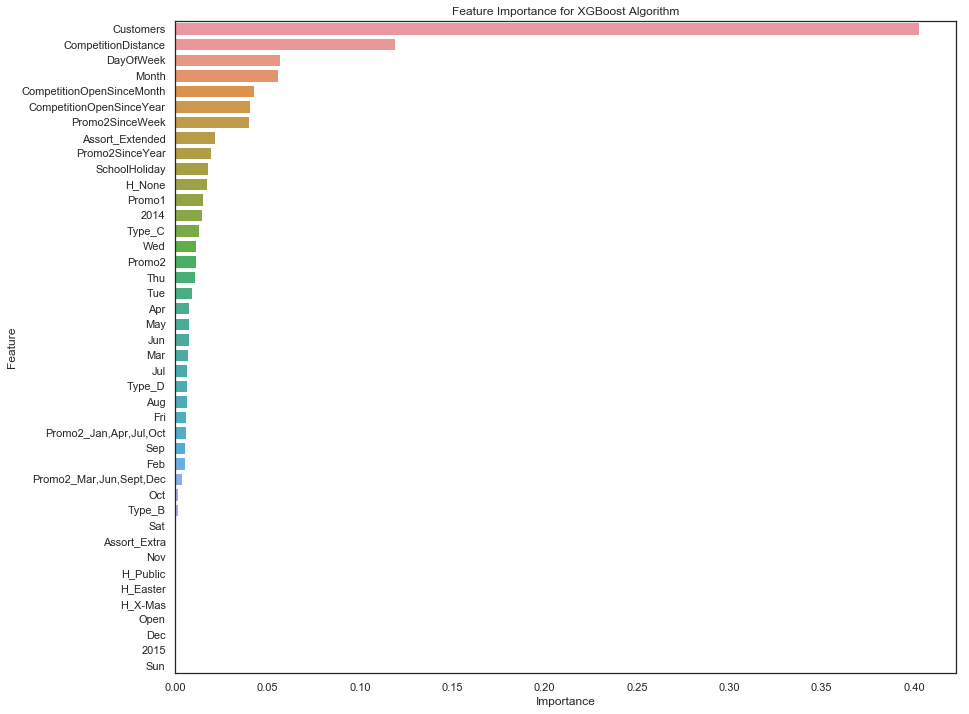

In [140]:
# Let's print features importance.

import matplotlib.pyplot as plt

plot_data = feature_importance_df[['Feature', 'Importance']].sort_values(by='Importance', ascending=False)

plt.figure(figsize=(14,12))

sns.barplot(x='Importance', y='Feature', data=plot_data)

plt.title('Feature Importance for XGBoost Algorithm')
plt.savefig('XGB_importances.png')

# Feature importance LightGBM

In [141]:
# LightGBM, along own code for earthquake prediction

feature_importance_df = pd.DataFrame()
feature_importance_df['Feature'] = train_columns
feature_importance_df['Importance'] = lgb.feature_importances_[:len(train_columns)]

print('Yey, done!')

Yey, done!


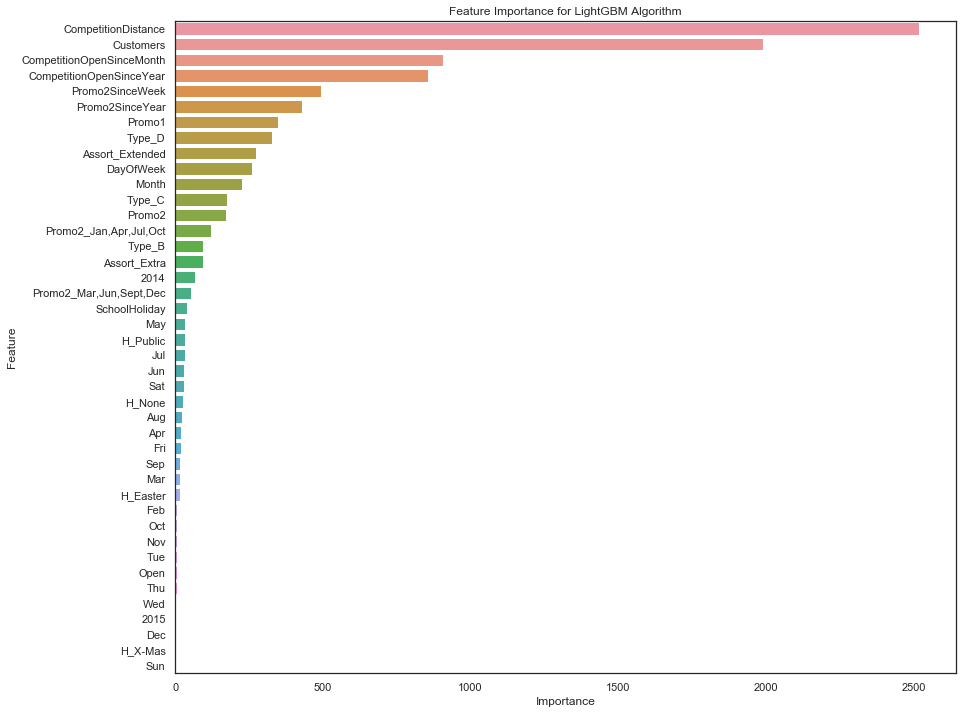

In [142]:
# Let's print features importance.

import matplotlib.pyplot as plt

plot_data = feature_importance_df[['Feature', 'Importance']].sort_values(by='Importance', ascending=False)

plt.figure(figsize=(14,12))

sns.barplot(x='Importance', y='Feature', data=plot_data)

plt.title('Feature Importance for LightGBM Algorithm')
plt.savefig('lgb_importances.png')

# Stacked models

In [217]:
# Making train and test predictions with three performers and concatenating into stacked dataframe

start_time = datetime.now()

XGB_pred_train = XGB.predict(X_train)
XGB_pred_true = XGB.predict(X_true)
lgb_pred_train = lgb.predict(X_train)
lgb_pred_true = lgb.predict(X_true)
MLP_pred_train = MLP.predict(X_train)
MLP_pred_true = MLP.predict(X_true)

XGB_pred_train = pd.DataFrame(XGB_pred_train)
XGB_pred_true = pd.DataFrame(XGB_pred_true)
lgb_pred_train = pd.DataFrame(lgb_pred_train)
lgb_pred_true = pd.DataFrame(lgb_pred_true)
MLP_pred_train = pd.DataFrame(MLP_pred_train)
MLP_pred_true = pd.DataFrame(MLP_pred_true)

df_train = pd.concat([XGB_pred_train, lgb_pred_train, MLP_pred_train], axis=1)
df_true = pd.concat([XGB_pred_true, lgb_pred_true, MLP_pred_true], axis=1)

time_elapsed = datetime.now() - start_time 

print(len(df_train))
print(len(y_train))
print(len(df_test))
print(len(y_test))

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

712046
712046
152581
152581
Time elapsed (hh:mm:ss.ms) 0:01:20.057875


In [218]:
# Stacking

from sklearn.linear_model import LinearRegression

start_time = datetime.now()

l_reg = linear_model.LinearRegression()
l_reg.fit(df_train, y_train)
stacked_lr_pred = l_reg.predict(df_true)

regressor = 'Stacked XGB, LGB, MLP (true)'
RMSPE = RMSPE_fct(y_true, stacked_lr_pred)
MSE = mean_squared_error(y_true, stacked_lr_pred)
R2 = r2_score(y_true, stacked_lr_pred)

# time 

time_elapsed = datetime.now() - start_time 

# scores 

scores = scores.append(pd.Series([regressor, RMSPE, MSE, R2, time_elapsed], index=scores.columns), ignore_index=True)

print('Mean squared error: %.2f' % MSE)
print('Root mean squared percentage error: %.2f' % RMSPE)
print('Variance score: %.2f' % R2)
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Mean squared error: 463520.39
Root mean squared percentage error: 0.08
Variance score: 0.97
Time elapsed (hh:mm:ss.ms) 0:00:00.117359


# Final performance comparison

In [222]:
scores

,Regressor,RMSPE,MSE,R2,Time
0,Linear Reg,0.184117,1.474975e+06,0.907479,0 days 00:00:00.999722
1,LinearSVR,1.016006,2.194094e+07,-0.376297,0 days 00:04:20.598299
2,ElasticNet,0.199590,2.348652e+06,0.852675,0 days 00:00:01.245563
3,Lasso,0.182485,1.474664e+06,0.907498,0 days 00:00:07.476967
4,LGBM,0.134949,6.267752e+05,0.960684,0 days 00:00:05.742142
5,XGBoost,0.128395,9.476068e+05,0.940559,0 days 00:01:22.458597
6,Neural Net,0.131720,9.416260e+05,0.940934,0 days 00:07:59.506354
7,AdaBoost,0.184656,1.474300e+06,0.907521,0 days 00:01:47.173080
8,LGBM (tuned),0.120544,4.045873e+05,0.974621,0 days 00:00:08.645948
9,MLP (tuned),0.125380,9.616606e+05,0.939678,0 days 00:18:18.715265
